Functions on winning_chances.py:

0. `convert_evaluation(row)`
1. `calculate_chances(df, lower_eval, upper_eval)`
2. `compute_winning_chance_table(df, intervals=np.arange(-13, 13.2, 0.2))`
3. `process_chess_data(df, winning_chance_table=pd.read_csv('winning_chances_all_moves.csv'), intervals=np.arange(-13, 13.2, 0.2))`
4. `create_summary_table(df, mistake_bins= [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100], winning_chance_table=None, intervals=None)`

In [ ]:
import winning_chances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [124]:
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")
table=winning_chances.compute_winning_chance_table(df)
summary_table=winning_chances.create_summary_table(df,mistake_bins=mistake_bins,winning_chance_table=table)

#table=pd.read_csv("winning_chances_all_moves.csv")
#summary_table=pd.read_csv("../huge_analyzed_games/big_summary_table.csv")

In [125]:
new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
#new_summary_table=summary_table.copy()
#new_summary_table = summary_table[summary_table['Player'] == 'Black'].copy()

# Define categorical features to process
start_index = new_summary_table.columns.get_loc('TotalMovesInterval') + 1
mistake_labels = list(new_summary_table.columns[start_index:])

categorical_features = ['Opening', 'Result', 'TotalMovesInterval']
#numerical_features=mistake_labels + ['WeightedMistakeScore']
numerical_features=mistake_labels 

# Define total moves bins and create total moves labels
total_moves_bins = [0, 40,  60,  80,  100, 120, np.inf]
total_moves_labels = [
    f'({total_moves_bins[i]},{total_moves_bins[i+1]}]' if not np.isinf(total_moves_bins[i + 1]) else f'({total_moves_bins[i]},∞]'
    for i in range(len(total_moves_bins) - 1)
]

# Create 'TotalMovesInterval' using pd.cut
new_summary_table['TotalMovesInterval'] = pd.cut(
    new_summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Handle missing values in the target variable
new_summary_table = new_summary_table.dropna(subset=['Elo'])


# Process categorical features
for col in categorical_features:
    # Convert to 'category' dtype
    new_summary_table[col] = new_summary_table[col].astype('category')
    # Add 'Unknown' to categories if not present
    if 'Unknown' not in new_summary_table[col].cat.categories:
        new_summary_table[col] = new_summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    new_summary_table[col] = new_summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
new_summary_table[mistake_labels] = new_summary_table[mistake_labels].fillna(0)

# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")




# Get the names of the categorical features after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine with numerical feature names
all_feature_names = np.concatenate([onehot_feature_names, mistake_labels])
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort the coefficients by absolute value
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the top 5 features with the highest absolute coefficients
print("\nTop 5 features by absolute coefficient value:")
print(coef_df[['Feature', 'Coefficient']].head(5))

mistake_coef_df = coef_df[coef_df['Feature'].isin(mistake_labels)]

# Display the coefficients for the mistake features
print("\nCoefficients for the mistake labels:")
print(mistake_coef_df[['Feature', 'Coefficient']])

Root Mean Squared Error (RMSE): 257.60
R-squared Score (R²): 0.17
Percentage of predictions within ±300 Elo: 77.77%

Top 5 features by absolute coefficient value:
                                               Feature  Coefficient
29                              Opening_Canard opening  -840.717551
97                       Opening_King's knight opening  -772.668033
35   Opening_Clemenz (Mead's, Basman's or de Klerk'...  -569.210528
195                             Opening_Scotch opening  -426.988335
217          Opening_Vienna gambit, Steinitz variation   384.230424

Coefficients for the mistake labels:
      Feature  Coefficient
242  (70,100]   -58.876378
239   (40,50]   -35.559936
237   (30,35]   -32.866167
236   (25,30]   -31.230737
238   (35,40]   -29.990735
241   (60,70]   -23.578542
235   (20,25]   -22.592081
240   (50,60]   -20.983387
234   (15,20]   -16.728455
233   (10,15]   -14.354998
232    (5,10]    -2.056610


In [126]:
# Step 1: Create a dictionary of mistake coefficients
mistake_coefficients = mistake_coef_df.set_index('Feature')['Coefficient'].to_dict()

# Normalize the coefficients so that the sum of their absolute values is 1
total_weight = sum(abs(coef) for coef in mistake_coefficients.values())
normalized_coefficients = {k: abs(v) / total_weight for k, v in mistake_coefficients.items()}

# Step 2: Compute WeightedMistakeScore using normalized coefficients
new_summary_table['WeightedMistakeScore'] = 0.0
for label in mistake_labels:
    coefficient = normalized_coefficients.get(label, 0)
    new_summary_table['WeightedMistakeScore'] += new_summary_table[label] * coefficient


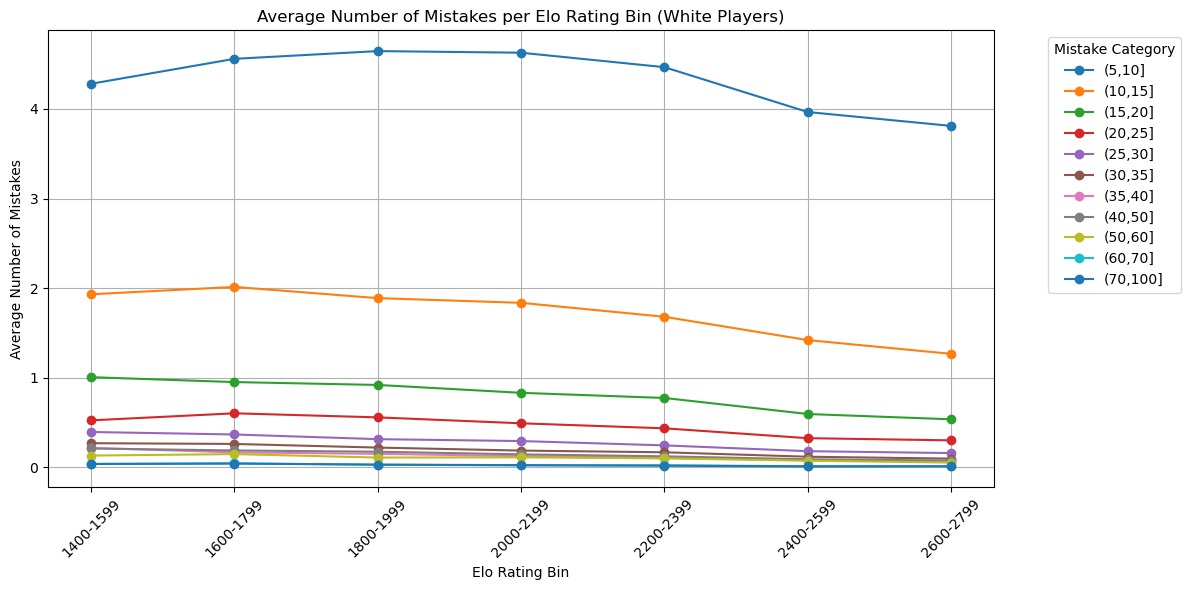

C:\Users\foivo\AppData\Local\Temp\ipykernel_23488\2409424698.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin')['WeightedMistakeScore'].mean().reset_index()


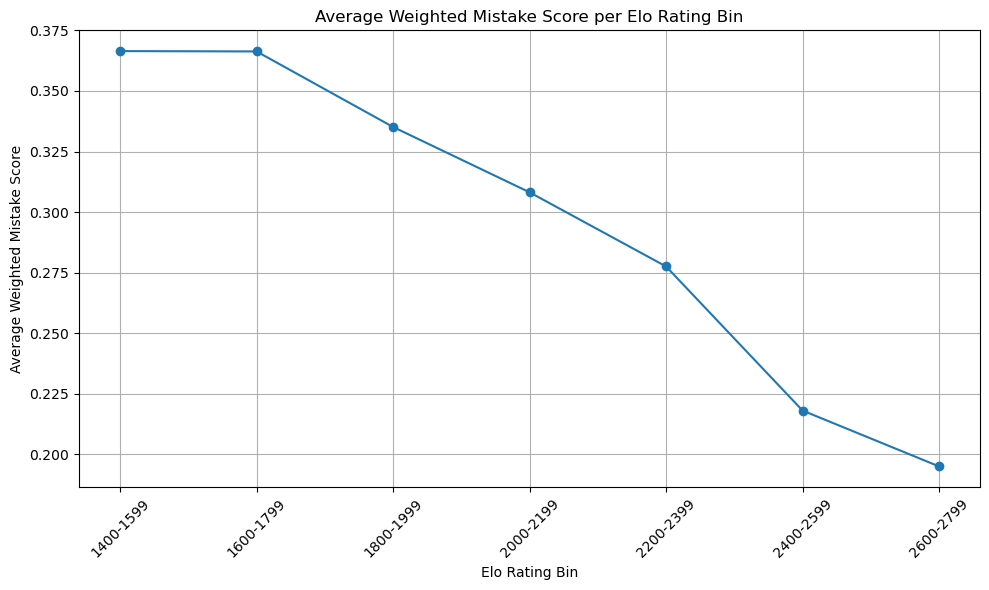

In [128]:
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    if np.isinf(upper):
        label = f'{int(lower)}+'
    else:
        upper = upper - 1  # Subtract 1 to make the upper limit inclusive
        label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
new_summary_table['EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Remove rows with missing 'EloBin' values
new_summary_table = new_summary_table.dropna(subset=['EloBin'])

# Step 2: Aggregate the Data
# Group by EloBin and calculate the average number of mistakes in each category
avg_mistakes_per_bin = new_summary_table.groupby('EloBin', observed=False)[mistake_labels].mean().reset_index()

# Step 3: Plot the Data
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot a line for each mistake category
for label in mistake_labels:
    plt.plot(
        avg_mistakes_per_bin['EloBin'],
        avg_mistakes_per_bin[label],
        marker='o',
        label=label
    )

# Customize the plot
plt.title('Average Number of Mistakes per Elo Rating Bin (White Players)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Number of Mistakes')
plt.xticks(rotation=45)
plt.legend(title='Mistake Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Assuming 'new_summary_table', 'mistake_labels', and 'mistake_coef_df' are already defined


# Step 3: Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]
elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1] - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)
# Assign Elo bins to the data
new_summary_table['EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Compute average WeightedMistakeScore per Elo bin
avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin')['WeightedMistakeScore'].mean().reset_index()



# Plot the line graph connecting the averages
plt.figure(figsize=(10, 6))
plt.plot(avg_mistake_per_elo_bin['EloBin'], avg_mistake_per_elo_bin['WeightedMistakeScore'], marker='o')
plt.title('Average Weighted Mistake Score per Elo Rating Bin')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Weighted Mistake Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
new_summary_table.columns

Index(['GameID', 'Player', 'Name', 'Elo', 'FideId', 'Opening', 'Variation',
       'Result', 'TotalMoves', 'TotalMovesInterval', '(5,10]', '(10,15]',
       '(15,20]', '(20,25]', '(25,30]', '(30,35]', '(35,40]', '(40,50]',
       '(50,60]', '(60,70]', '(70,100]'],
      dtype='object')

In [120]:

# Define categorical features to process

categorical_features = ['Opening', 'Result', 'TotalMovesInterval']
numerical_features= mistake_labels+['WeightedMistakeScore']


# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")






Root Mean Squared Error (RMSE): 248.45
R-squared Score (R²): 0.08
Percentage of predictions within ±300 Elo: 78.49%


In [121]:
new_summary_table.head()

,GameID,Player,Name,Elo,FideId,Opening,Variation,Result,TotalMoves,TotalMovesInterval,...,"(20,25]","(25,30]","(30,35]","(35,40]","(40,50]","(50,60]","(60,70]","(70,100]",WeightedMistakeScore,EloBin
1,1.0,White,"Topalov,V",2749.0,2900084.0,Caro-Kann,advance variation,1/2-1/2,65.0,"(60,80]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149307,2600-2799
3,2.0,White,"Caruana,F",2799.0,2020009.0,Sicilian,"Najdorf, Opovcensky variation",1-0,109.0,"(100,120]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105486,2600-2799
5,3.0,White,"So,W",2788.0,5202213.0,Ruy Lopez,Berlin defence,1/2-1/2,113.0,"(100,120]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029861,2600-2799
7,4.0,White,"Nakamura,Hi",2780.0,2016192.0,Vienna,Paulsen-Mieses variation,1-0,119.0,"(100,120]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731571,2600-2799
9,5.0,White,"Grischuk,A",2782.0,4126025.0,QGA,3.e4,1/2-1/2,161.0,"(120,∞]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256735,2600-2799


In [123]:
player_name = 'Caruana Fabiano'
player_fide_id = 2020009 
# Filter for games where 'PlayerName' is the player
player_games = new_summary_table[new_summary_table['FideId'] == player_fide_id].copy()

# Select 5 games
player_games = player_games.head(20)

X_player_games = player_games[categorical_features + numerical_features].copy()

# Process categorical features
for col in categorical_features:
    X_player_games[col] = X_player_games[col].astype('category')
    if 'Unknown' not in X_player_games[col].cat.categories:
        X_player_games[col] = X_player_games[col].cat.add_categories(['Unknown'])
    X_player_games[col] = X_player_games[col].fillna('Unknown')

# Handle missing values in numerical features
X_player_games[numerical_features] = X_player_games[numerical_features].fillna(0)

# Predict
y_pred_player = pipeline.predict(X_player_games)

# Print the predictions
for i, pred in enumerate(y_pred_player):
    print(f"Game {i+1} predicted Elo: {pred:.2f}")

# Print the average of the predictions
average_pred = y_pred_player.mean()
print(f"Average predicted Elo for {player_name}: {average_pred:.2f}")


Game 1 predicted Elo: 2328.51
Game 2 predicted Elo: 2247.07
Game 3 predicted Elo: 2336.62
Game 4 predicted Elo: 2368.02
Game 5 predicted Elo: 2246.40
Game 6 predicted Elo: 2264.83
Game 7 predicted Elo: 2265.44
Game 8 predicted Elo: 2368.79
Game 9 predicted Elo: 2308.52
Game 10 predicted Elo: 2260.49
Game 11 predicted Elo: 2208.10
Game 12 predicted Elo: 2342.74
Game 13 predicted Elo: 2361.55
Game 14 predicted Elo: 2295.44
Game 15 predicted Elo: 2377.44
Game 16 predicted Elo: 2330.95
Game 17 predicted Elo: 2226.40
Game 18 predicted Elo: 2434.17
Game 19 predicted Elo: 2208.28
Game 20 predicted Elo: 2255.40
Average predicted Elo for Caruana Fabiano: 2301.76
